# Tuning a `multi_match` `most_fields` query

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [3]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev_templated, optimize_query_mrr100_templated, set_bm25_params
from qopt.optimize import Config

In [4]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
es = Elasticsearch('http://localhost:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 10

index = 'msmarco-document.doc2query'
template_id = 'query'
query_type = 'most_fields'

# set best BM25 params
set_bm25_params(es, index, [
    ('url', {'k1': 0.33066956222950633, 'b': 0.9589101032169087}), # 0.2201
    ('title', {'k1': 0.34885436112727763, 'b': 1.0}), # 0.2354
    ('title.bigrams', {'k1': 1.2, 'b': 0.75}), # 0.1295
    ('body', {'k1': 3.0128735487205525, 'b': 0.8200709176657588}), # 0.2645
    ('body.bigrams', {'k1': 1.9100199633100623, 'b': 0.7336619962002098}), # 0.2045
    ('expansions', {'k1': 4.870954366799399, 'b': 0.9249613913608172}), # 0.3220
    ('expansions.bigrams', {'k1': 1.2, 'b': 0.75}) # 0.2837
])

# base template for tuning
base_templates = [{
    "id": template_id,
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

Setting BM25 params fields:
 - url: {'k1': 0.33066956222950633, 'b': 0.9589101032169087}
 - title: {'k1': 0.34885436112727763, 'b': 1.0}
 - title.bigrams: {'k1': 1.2, 'b': 0.75}
 - body: {'k1': 3.0128735487205525, 'b': 0.8200709176657588}
 - body.bigrams: {'k1': 1.9100199633100623, 'b': 0.7336619962002098}
 - expansions: {'k1': 4.870954366799399, 'b': 0.9249613913608172}
 - expansions.bigrams: {'k1': 1.2, 'b': 0.75}


## Experiments

### Base fields

In [5]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
    ]
}

In [6]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2866
CPU times: user 1.87 s, sys: 548 ms, total: 2.42 s
Wall time: 2min 35s


In [7]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:35 (remains: 0:28:59)
   | 0.2258 (best: 0.2258) - {'url|boost': 2.3238513494968465, 'title|boost': 9.646148895586501, 'body|boost': 0.38400616693785034}
 > iteration 2/50, took 0:00:28 (remains: 0:22:51)
   | 0.2780 (best: 0.2780) - {'url|boost': 1.0282402606853827, 'title|boost': 5.620614617420669, 'body|boost': 9.993215193304582}
 > iteration 3/50, took 0:00:23 (remains: 0:18:16)
   | 0.2495 (best: 0.2780) - {'url|boost': 9.553248081080604, 'title|boost': 1.5748881225250224, 'body|boost': 3.2614301427054544}
 > iteration 4/50, took 0:00:24 (remains: 0:18:26)
   | 0.2583 (best: 0.2780) - {'url|boost': 6.507299764796497, 'title|boost': 5.987881219913318, 'body|boost': 4.881867345452938}
 > iteration 5/50, took 0:00:17 (remains: 0:13:22)
   | 0.2612 (best: 0.2780) - {'url|boost': 3.3769929734787656,

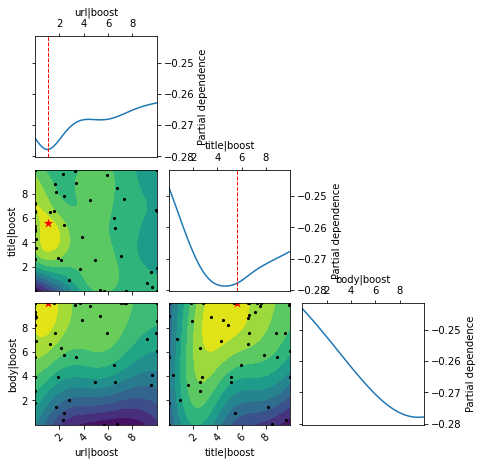

In [8]:
_ = plot_objective(metadata, sample_source='result')

In [9]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3001
CPU times: user 2.14 s, sys: 718 ms, total: 2.86 s
Wall time: 2min 27s


In [10]:
final_params

{'url|boost': 1.0282402606853827,
 'title|boost': 5.620614617420669,
 'body|boost': 9.993215193304582}

### Base fields + bigrams

In [11]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
    ]
}

In [12]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2696
CPU times: user 2.07 s, sys: 732 ms, total: 2.8 s
Wall time: 5min 28s


In [13]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:12 (remains: 0:58:59)
   | 0.2345 (best: 0.2345) - {'url|boost': 6.41798492751675, 'title|boost': 2.1259847739071542, 'title_bigrams|boost': 9.627474515682819, 'body|boost': 7.9444381406927995, 'body_bigrams|boost': 0.5006531529245696}
 > iteration 2/50, took 0:01:16 (remains: 1:01:20)
   | 0.2300 (best: 0.2345) - {'url|boost': 1.1889895874558045, 'title|boost': 2.9181231644829526, 'title_bigrams|boost': 9.047851285364732, 'body|boost': 5.739947073293478, 'body_bigrams|boost': 2.1298461201077994}
 > iteration 3/50, took 0:01:10 (remains: 0:55:28)
   | 0.2570 (best: 0.2570) - {'url|boost': 1.4043415809698447, 'title|boost': 8.681634215151325, 'title_bigrams|boost': 5.400657333981491, 'body|boost': 7.490654268448649, 'body_bigrams|boost': 5.131752248706935}
 > iteration 4/50, took 0:01:18 (remains: 1:

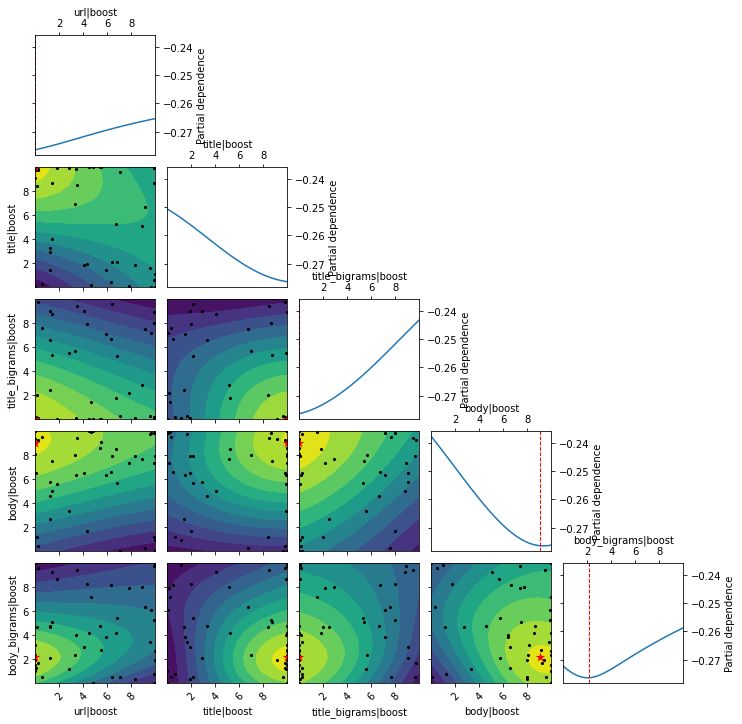

In [14]:
_ = plot_objective(metadata, sample_source='result')

In [15]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.2978
CPU times: user 1.88 s, sys: 520 ms, total: 2.4 s
Wall time: 5min 29s


In [16]:
final_params

{'url|boost': 0.0,
 'title|boost': 10.0,
 'title_bigrams|boost': 0.0,
 'body|boost': 9.035142069269364,
 'body_bigrams|boost': 2.164255730827308}

### Base fields + expansions

In [17]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "expansions^{{expansions|boost}}",
    ]
}

In [18]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.3269
CPU times: user 2.36 s, sys: 709 ms, total: 3.07 s
Wall time: 3min 3s


In [19]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:40 (remains: 0:32:48)
   | 0.3059 (best: 0.3059) - {'url|boost': 5.00796046814467, 'title|boost': 4.467783894901453, 'body|boost': 4.3421341461708085, 'expansions|boost': 5.800312865732512}
 > iteration 2/50, took 0:00:31 (remains: 0:25:22)
   | 0.3063 (best: 0.3063) - {'url|boost': 9.900212103351505, 'title|boost': 2.9678411831352585, 'body|boost': 4.210396805793027, 'expansions|boost': 9.58146939432874}
 > iteration 3/50, took 0:00:20 (remains: 0:15:44)
   | 0.2237 (best: 0.3063) - {'url|boost': 4.115460476754257, 'title|boost': 7.566511649035447, 'body|boost': 0.20180602959628205, 'expansions|boost': 0.1320712195305707}
 > iteration 4/50, took 0:00:30 (remains: 0:23:44)
   | 0.3127 (best: 0.3127) - {'url|boost': 1.2764646941966853, 'title|boost': 3.816396715312197, 'body|boost': 4.726679031773983

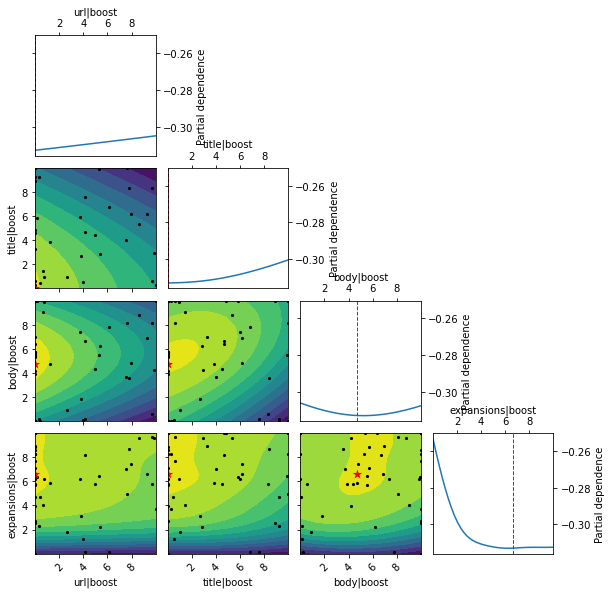

In [20]:
_ = plot_objective(metadata, sample_source='result')

In [21]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3292
CPU times: user 1.9 s, sys: 525 ms, total: 2.42 s
Wall time: 2min 37s


In [22]:
final_params

{'url|boost': 0.0,
 'title|boost': 0.0,
 'body|boost': 4.718961462119655,
 'expansions|boost': 6.651327961195701}

### Base fields + expansions + bigrams

In [23]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

In [24]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3203
CPU times: user 2.49 s, sys: 789 ms, total: 3.27 s
Wall time: 7min 8s


In [25]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 100,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/100, took 0:01:32 (remains: 2:32:49)
   | 0.2979 (best: 0.2979) - {'url|boost': 4.618073524497234, 'title|boost': 6.347797803061562, 'title_bigrams|boost': 4.612678587028035, 'body|boost': 8.760882962170575, 'body_bigrams|boost': 2.801913185073393, 'expansions|boost': 6.8038187155703875, 'expansions_bigrams|boost': 1.625454928483412}
 > iteration 2/100, took 0:01:30 (remains: 2:27:05)
   | 0.2783 (best: 0.2979) - {'url|boost': 3.940247461430019, 'title|boost': 4.144918701613149, 'title_bigrams|boost': 6.804427187711721, 'body|boost': 4.809265927658287, 'body_bigrams|boost': 2.004720016733041, 'expansions|boost': 3.8320986376781874, 'expansions_bigrams|boost': 1.3469527218406365}
 > iteration 3/100, took 0:01:32 (remains: 2:28:59)
   | 0.2724 (best: 0.2979) - {'url|boost': 0.5660704127591855, 'title|boost': 6.3519

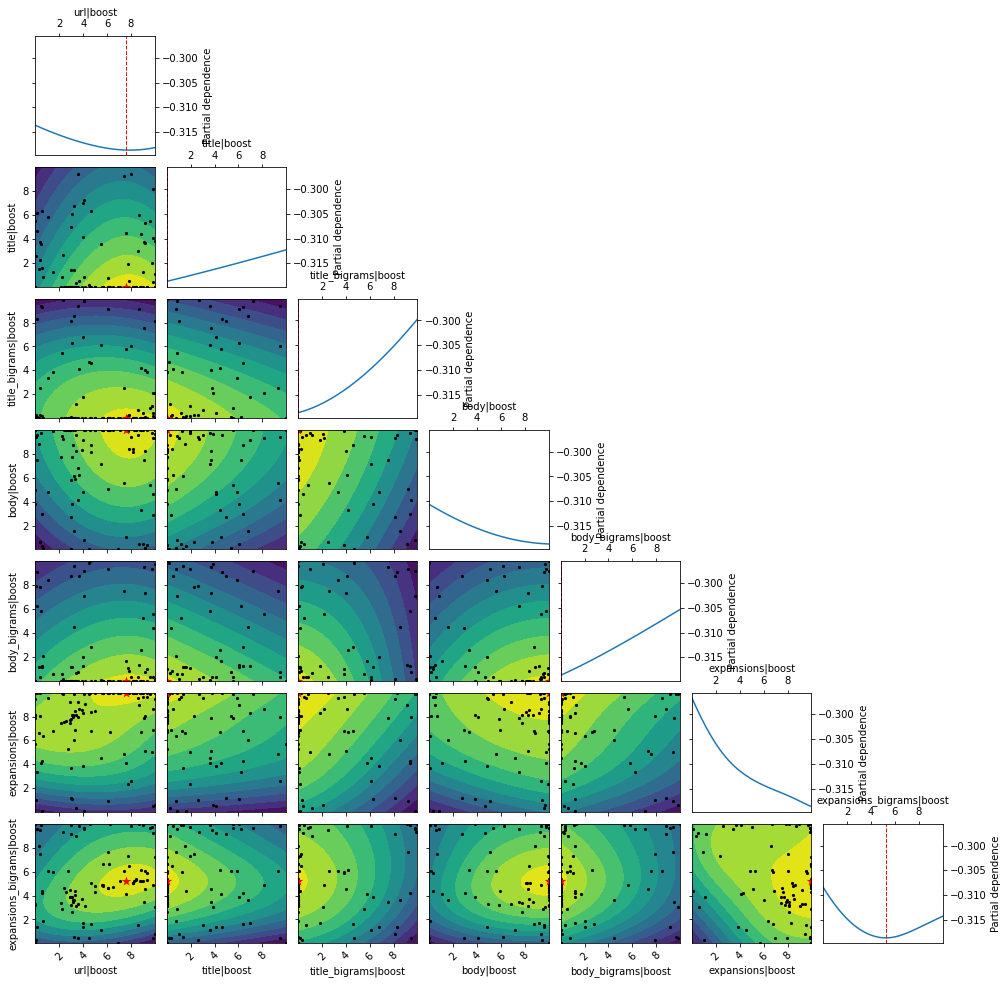

In [26]:
_ = plot_objective(metadata, sample_source='result')

In [27]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3413
CPU times: user 2.18 s, sys: 696 ms, total: 2.88 s
Wall time: 7min 6s


In [28]:
final_params

{'url|boost': 7.5510316594810964,
 'title|boost': 0.0,
 'title_bigrams|boost': 0.0,
 'body|boost': 10.0,
 'body_bigrams|boost': 0.0,
 'expansions|boost': 10.0,
 'expansions_bigrams|boost': 5.243287957841142}

In [29]:
# with 100/20 iterations
# 0.3416

{
    'url|boost': 5.019618907965658,
    'title|boost': 2.1715172653248564,
    'title_bigrams|boost': 0.6258343432390224,
    'body|boost': 8.97005088495938,
    'body_bigrams|boost': 0.785011613141371,
    'expansions|boost': 9.958043226768973,
    'expansions_bigrams|boost': 2.6104666149721205
}

{'url|boost': 5.019618907965658,
 'title|boost': 2.1715172653248564,
 'title_bigrams|boost': 0.6258343432390224,
 'body|boost': 8.97005088495938,
 'body_bigrams|boost': 0.785011613141371,
 'expansions|boost': 9.958043226768973,
 'expansions_bigrams|boost': 2.6104666149721205}

### Selective fields

Based on the results from above, remove fields with `0` boost values.

In [5]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "body^{{body|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

In [6]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'url|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3389
CPU times: user 2.28 s, sys: 582 ms, total: 2.87 s
Wall time: 3min 49s


In [7]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 100,
        'num_initial_points': 20,
        'space': {
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/100, took 0:00:45 (remains: 1:14:20)
   | 0.3058 (best: 0.3058) - {'url|boost': 1.147563481352111, 'body|boost': 9.391373646228002, 'expansions|boost': 4.610286661298312, 'expansions_bigrams|boost': 0.08416273154994715}
 > iteration 2/100, took 0:00:39 (remains: 1:04:56)
   | 0.3123 (best: 0.3123) - {'url|boost': 8.626188380362434, 'body|boost': 8.77578117306514, 'expansions|boost': 2.758633986506642, 'expansions_bigrams|boost': 5.173977176286209}
 > iteration 3/100, took 0:00:35 (remains: 0:58:06)
   | 0.3189 (best: 0.3189) - {'url|boost': 1.8850737104040243, 'body|boost': 6.366786252385932, 'expansions|boost': 5.229730074164991, 'expansions_bigrams|boost': 2.5442553893272586}
 > iteration 4/100, took 0:00:34 (remains: 0:55:19)
   | 0.3108 (best: 0.3189) - {'url|boost': 3.474698073943168, 'body|boost': 5.9789245

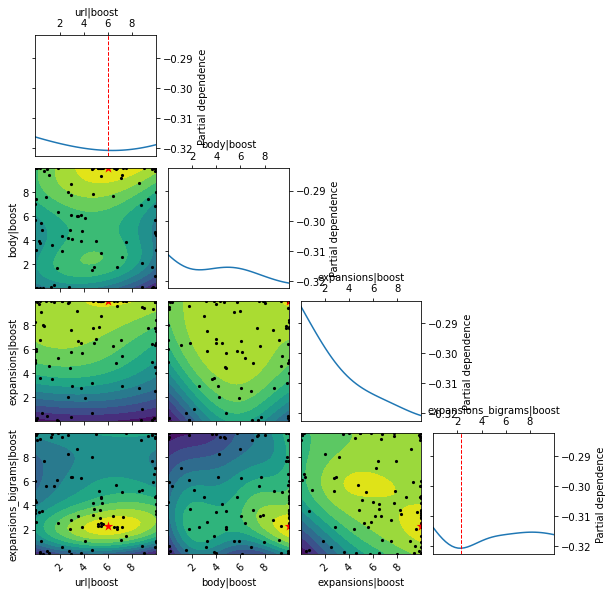

In [8]:
_ = plot_objective(metadata, sample_source='result')

In [9]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3425
CPU times: user 1.76 s, sys: 585 ms, total: 2.34 s
Wall time: 2min 30s


In [10]:
final_params

{'url|boost': 5.9772866071225605,
 'body|boost': 10.0,
 'expansions|boost': 10.0,
 'expansions_bigrams|boost': 2.283163846176233}

In [ ]:
# with 100/20 iterations
# 0.3425

{
    'url|boost': 5.9772866071225605,
    'body|boost': 10.0,
    'expansions|boost': 10.0,
    'expansions_bigrams|boost': 2.283163846176233
}